# Switching Ablation

This notebook studies how scaling conversion costs by a factor $\alpha$ and enabling the planner's pre-pass cost comparison impacts
QuASAr's backend selection and runtime.  For a small set of representative
circuits we evaluate $\alpha \in \{0.5, 1, 2, 5\}$ and visualise the resulting
plans.


In [1]:
import inspect
import sys, time, pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Make project root importable
root = pathlib.Path('..', '..').resolve()
sys.path.append(str(root))

from quasar.planner import Planner
from quasar.simulation_engine import SimulationEngine
from benchmarks.circuits import ghz_circuit, grover_circuit


In [2]:
alphas = [0.5, 1, 2, 5]
circuits = {
    'GHZ_6': ghz_circuit(6),
    'Grover_3': grover_circuit(3, 1),
}
records = []
for name, circ in circuits.items():
    for alpha in alphas:
        kwargs = {'conversion_cost_multiplier': alpha}
        if 'compare_pre_pass_costs' in inspect.signature(Planner).parameters:
            kwargs['compare_pre_pass_costs'] = True
        planner = Planner(**kwargs)
        engine = SimulationEngine(planner=planner)
        start = time.perf_counter()
        result = engine.simulate(circ)
        elapsed = time.perf_counter() - start
        steps = [s.backend.name for s in result.plan.steps]
        records.append({'circuit': name, 'alpha': alpha, 'steps': steps, 'runtime': elapsed})
records
results = records
circuits = list(circuits.keys())


/tmp/ipykernel_5620/2497480058.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heat_numeric = heat.replace(mapping).astype(float)


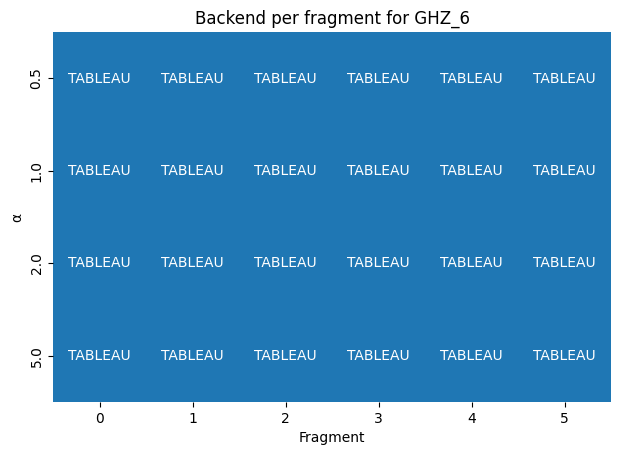

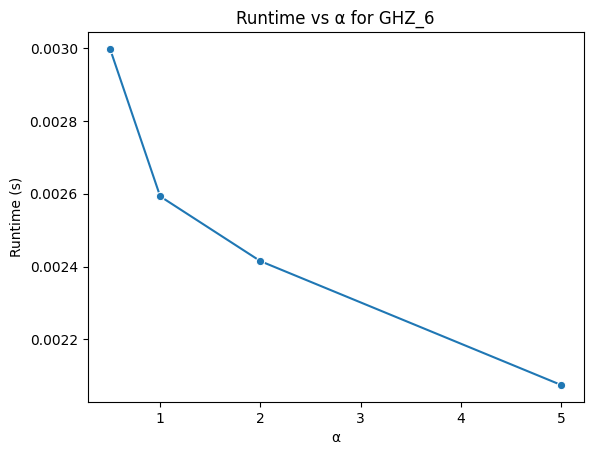

/tmp/ipykernel_5620/2497480058.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heat_numeric = heat.replace(mapping).astype(float)


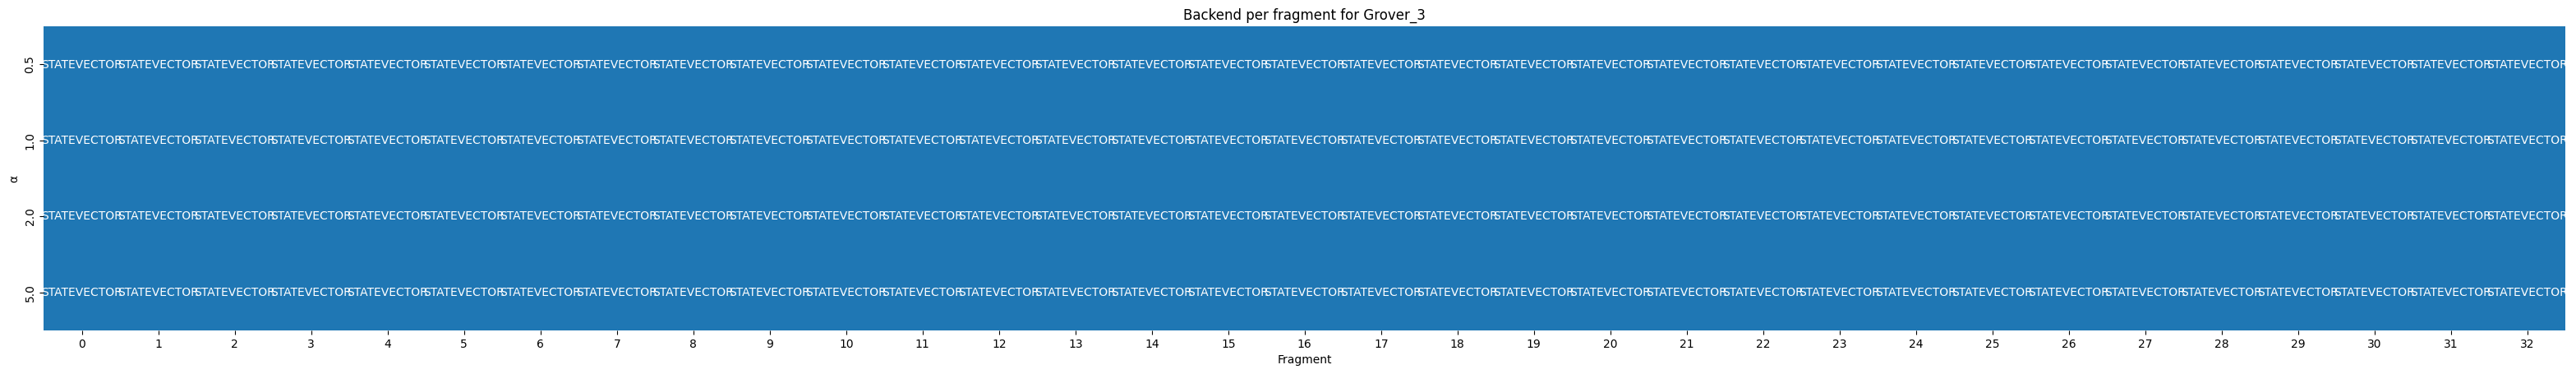

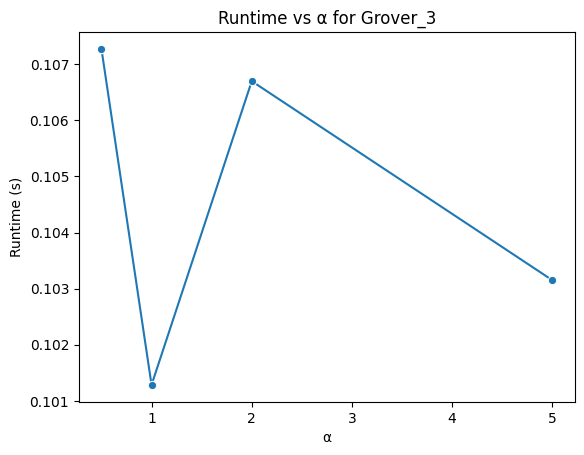

In [3]:
for name in circuits:
    subset = [r for r in records if r['circuit'] == name]
    max_frag = max(len(r['steps']) for r in subset)
    heat = pd.DataFrame(index=alphas, columns=range(max_frag))
    for r in subset:
        heat.loc[r['alpha'], :len(r['steps'])-1] = r['steps']
    backends = sorted({b for row in heat.values for b in row if b is not None})
    mapping = {b: i for i, b in enumerate(backends)}
    heat_numeric = heat.replace(mapping).astype(float)
    plt.figure(figsize=(1.2*max_frag, 1.2*len(alphas)))
    sns.heatmap(heat_numeric, annot=heat, fmt='', cmap='tab10', cbar=False)
    plt.title(f'Backend per fragment for {name}')
    plt.xlabel('Fragment')
    plt.ylabel('α')
    plt.show()

    runtime_df = pd.DataFrame({'alpha': [r['alpha'] for r in subset],
                               'runtime': [r['runtime'] for r in subset]})
    plt.figure()
    sns.lineplot(data=runtime_df, x='alpha', y='runtime', marker='o')
    plt.title(f'Runtime vs α for {name}')
    plt.xlabel('α')
    plt.ylabel('Runtime (s)')
    plt.show()


The plots above illustrate how enabling the pre-pass comparison guides backend selection and affects runtime across different conversion cost multipliers. In this configuration GHZ_6 remains on the TABLEAU backend for all $\alpha$, while Grover_3 consistently uses STATEVECTOR with only minor runtime variation.


In [4]:
import pandas as pd
from benchmarks.stats_utils import stats_table

def add_stats(df, quasar_col='QuASAr', baseline_cols=None, test='ttest', correction='bonferroni'):
    """Compute statistics comparing QuASAr with baselines.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with per-circuit results. One column must correspond to QuASAr,
        others to baselines.
    quasar_col : str
        Name of the column containing QuASAr results.
    baseline_cols : list[str] | None
        Columns to treat as baselines. Defaults to all columns except quasar_col.
    test : str
        'ttest' or 'wilcoxon'.
    correction : str
        'bonferroni' or 'fdr_bh'.

    Returns
    -------
    pd.DataFrame
        Table with baseline name, statistic, corrected p-value, and effect size.
    """
    if baseline_cols is None:
        baseline_cols = [c for c in df.columns if c != quasar_col]
    baselines = {c: df[c] for c in baseline_cols}
    return stats_table(df[quasar_col], baselines, test=test, correction=correction)

# Example usage after computing results DataFrame named `results_df`:
# stats_df = add_stats(results_df)
# stats_df


In [5]:

# Record parameters and results
import json, pathlib
try:
    import ipynbname
    nb_name = ipynbname.path().stem
except Exception:  # pragma: no cover
    nb_name = 'notebook'

# Collect simple parameters from globals
_params = {
    k: v for k, v in globals().items()
    if not k.startswith('_') and isinstance(v, (int, float, str, bool, list, dict, tuple))
}
pathlib.Path('../results').mkdir(exist_ok=True)
with open(f"../results/{nb_name}_params.json", 'w') as f:
    json.dump(_params, f, indent=2)
if 'results' in globals():
    try:
        with open(f"../results/{nb_name}_results.json", 'w') as f:
            json.dump(results, f, indent=2)
    except TypeError:
        pass
print(json.dumps(_params, indent=2))


{
  "In": [
    "",
    "import inspect\nimport sys, time, pathlib\nimport pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\n# Make project root importable\nroot = pathlib.Path('..', '..').resolve()\nsys.path.append(str(root))\n\nfrom quasar.planner import Planner\nfrom quasar.simulation_engine import SimulationEngine\nfrom benchmarks.circuits import ghz_circuit, grover_circuit",
    "alphas = [0.5, 1, 2, 5]\ncircuits = {\n    'GHZ_6': ghz_circuit(6),\n    'Grover_3': grover_circuit(3, 1),\n}\nrecords = []\nfor name, circ in circuits.items():\n    for alpha in alphas:\n        kwargs = {'conversion_cost_multiplier': alpha}\n        if 'compare_pre_pass_costs' in inspect.signature(Planner).parameters:\n            kwargs['compare_pre_pass_costs'] = True\n        planner = Planner(**kwargs)\n        engine = SimulationEngine(planner=planner)\n        start = time.perf_counter()\n        result = engine.simulate(circ)\n        elapsed = time.perf_counter() - start\n 